In [10]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import defaultdict
import argparse
import ast
import sys
import gzip
import csv
import pprint
import pandas as pd
import neet.sensitivity as ns
import neet.boolean as nn
from neet.boolean.examples import c_elegans
from itertools import groupby
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
from matplotlib import gridspec
from matplotlib._png import read_png
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import datetime as dt

import collections

from scipy import stats
import scipy as sp
import community
from scipy.spatial.distance import pdist, squareform
from sklearn import datasets
from matplotlib import patches

from network_ei import *
from causal_emergence import *
from get_motifs import *

plt.rc('axes', axisbelow=True)
%matplotlib inline

In [3]:
tpm = np.array([[1,1,1,0,0],
                [1,1,1,0,0],
                [1,1,1,0,0],
                [0,0,0,1,0],
                [0,0,0,0,1]])

p0 = 0.0#001

causal_emergence(tpm,p0,thresh=0.0,printt=True)

Starting with this tpm:
 [[0.3333 0.3333 0.3333 0.     0.    ]
 [0.3333 0.3333 0.3333 0.     0.    ]
 [0.3333 0.3333 0.3333 0.     0.    ]
 [0.     0.     0.     1.     0.    ]
 [0.     0.     0.     0.     1.    ]]

Search started... current_ei = 1.3710
... 4 ... macro size = 5
... 3 ... macro size = 5
... 0 ... macro size = 5
just found successful macro grouping... current_ei = 1.5000
just found successful macro grouping... current_ei = 1.5850
... 1 ... macro size = 3
... 2 ... macro size = 3


(<networkx.classes.digraph.DiGraph at 0x1a1714bda0>,
 {0: 5, 1: 5, 2: 5, 3: 3, 4: 4},
 <networkx.classes.digraph.DiGraph at 0x1a1714b748>)

In [4]:
def unbalanced_barbell(n_left, n_right=100, n_connectors=1, p0=0):
    """
    Creates a barbell with n_left=some number less than n_right, connected by n_connectors
    """
    G1 = nx.complete_graph(n_left)
    for i in range(n_right):
        G1.add_node(i+n_left)
    for eij in range(n_connectors):
        G1.add_edge(eij, n_left+eij)
    for i in range(n_left, n_left+n_right):
        for j in range(n_left, n_left+n_right):
            if i!=j:
                G1.add_edge(i,j)
    G = prepare_network(G1, p0)
    
    return G

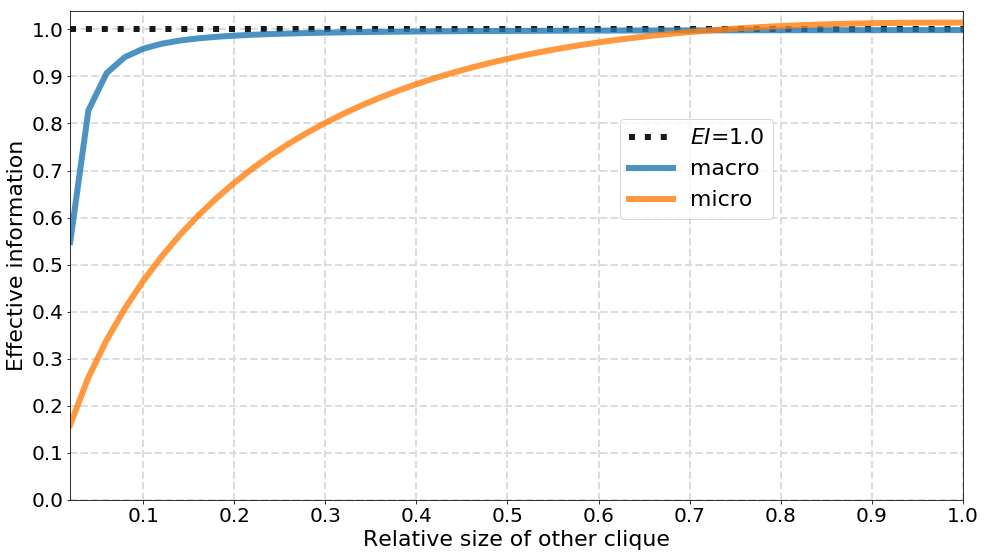

In [5]:
nmax = 100
n_con = 1
chunksizes = np.linspace(2,nmax,50,dtype=int)
macro_eis = []
micro_eis = []

for n in chunksizes:
    
    G = unbalanced_barbell(nmax,n,n_con,p0)
    micro_eis.append(get_ei(G, p0))

    if n==20:
        Gout = G.copy()
    micro_nodes_left = list(G.nodes())
    macro_mapping = dict(zip(micro_nodes_left, micro_nodes_left))
    leftout = len(micro_nodes_left)-nmax

    for i in range(nmax):
        macro_mapping[i] = G.number_of_nodes()

    for i in range(leftout):
        macro_mapping[i+nmax] = G.number_of_nodes()+1

    MACRO = get_macro(G, macro_mapping, p0)
    M_ei = get_ei(MACRO, p0)
    macro_eis.append(M_ei)

plt.figure(figsize=(16,9))

plt.plot(chunksizes/nmax, [1.0]*len(chunksizes), linestyle=':', 
         linewidth=6.0, alpha=0.9, color='k', label=r'$EI$=1.0')
plt.plot(chunksizes/nmax, macro_eis, linewidth=6.0, alpha=0.8, label='macro')
plt.plot(chunksizes/nmax, micro_eis, linewidth=6.0, alpha=0.8, label='micro')

plt.xticks(np.linspace(0, max(chunksizes)/nmax, 11), 
           np.round(np.linspace(0, max(chunksizes)/nmax, 11),2), fontsize=20)
plt.yticks(np.linspace(0, 1, 11), fontsize=20)
plt.xlabel("Relative size of other clique", fontsize=22)
plt.ylabel("Effective information", fontsize=22)
plt.xlim(min(chunksizes)/nmax, max(chunksizes)/nmax)
plt.ylim(0, 1.04)
plt.legend(bbox_to_anchor=(0.8,0.8), fontsize=22)
plt.grid(linewidth=2.0, color='gainsboro', linestyle='--')

# plt.savefig("../figs/pngs/CausalEmergence_Barbell_varyingN.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/CausalEmergence_Barbell_varyingN.pdf", bbox_inches='tight')
plt.show()

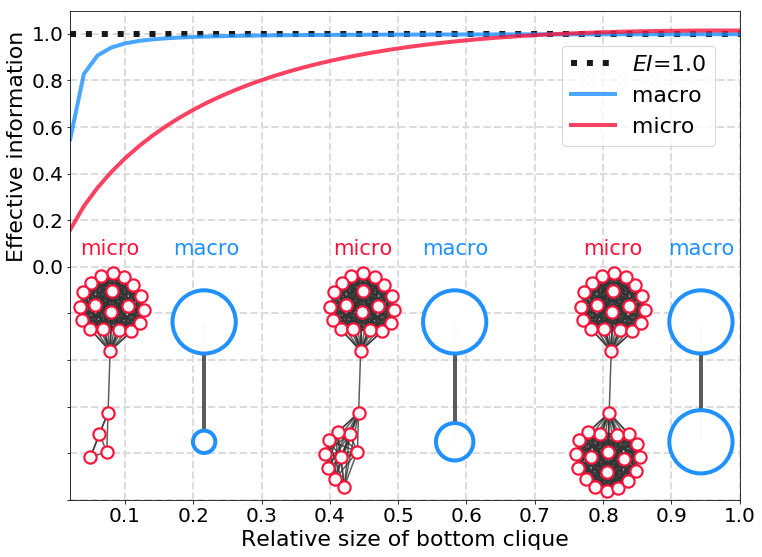

In [6]:
nmax = 100
n_con = 1
chunksizes = np.linspace(2,nmax,50,dtype=int)
macro_eis = []
micro_eis = []

for n in chunksizes:
    G = unbalanced_barbell(nmax,n,n_con,p0)
    micro_eis.append(get_ei(G, p0))

    if n==20:
        Gout = G.copy()
    micro_nodes_left = list(G.nodes())
    macro_mapping = dict(zip(micro_nodes_left, micro_nodes_left))
    leftout = len(micro_nodes_left)-nmax

    for i in range(nmax):
        macro_mapping[i] = G.number_of_nodes()

    for i in range(leftout):
        macro_mapping[i+nmax] = G.number_of_nodes()+1

    MACRO = get_macro(G, macro_mapping, p0)
    M_ei = get_ei(MACRO, p0)
    macro_eis.append(M_ei)

plt.figure(figsize=(12,9))
# plt.figure(figsize=(16,9))

plt.plot(chunksizes/nmax, [1.0]*len(chunksizes), linestyle=':', 
         linewidth=6.0, alpha=0.9, color='k', label=r'$EI$=1.0')
plt.plot(chunksizes/nmax, macro_eis, linewidth=4.0, alpha=0.8, color='dodgerblue', label='macro')
plt.plot(chunksizes/nmax, micro_eis, linewidth=4.0, alpha=0.8, color='#f9143b', label='micro')

plt.xticks(np.linspace(0, max(chunksizes)/nmax, 11), 
           np.round(np.linspace(0, max(chunksizes)/nmax, 11),2), fontsize=20)
plt.yticks(np.linspace(-1, 1, 11),
           ["","","","","", "0.0", "0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=20)
plt.xlabel("Relative size of bottom clique", fontsize=22)
plt.ylabel("                               Effective information", fontsize=22)
plt.xlim(min(chunksizes)/nmax, max(chunksizes)/nmax)
plt.ylim(-1, 1.1)
plt.legend(bbox_to_anchor=(0.98,0.95), fontsize=22)
plt.grid(linewidth=2.0, color='gainsboro', linestyle='--')

micro_string = 'micro'
macro_string = 'macro'

plt.text(0.035, 0.05, micro_string, ha='left', rotation=0, wrap=False, size=21, color='#f9143b')
plt.text(0.170, 0.05, macro_string, ha='left', rotation=0, wrap=False, size=21, color='dodgerblue')
plt.text(0.405, 0.05, micro_string, ha='left', rotation=0, wrap=False, size=21, color='#f9143b')
plt.text(0.535, 0.05, macro_string, ha='left', rotation=0, wrap=False, size=21, color='dodgerblue')
plt.text(0.770, 0.05, micro_string, ha='left', rotation=0, wrap=False, size=21, color='#f9143b')
plt.text(0.895, 0.05, macro_string, ha='left', rotation=0, wrap=False, size=21, color='dodgerblue')



# plt.axes([0.70, 0.14, 0.1, 0.45])
plt.axes([0.70, 0.122, 0.1, 0.37])
G = nx.to_undirected(unbalanced_barbell(20, 20, 1, 0))
plt.axis('off')
pos23 = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G, pos23, node_color='white', node_size=150, 
                       linewidths=2.2, alpha=0.99).set_edgecolor('#f9143b')
nx.draw_networkx_edges(G, pos23, edge_color="#333333", width=1.5, alpha=0.8)
plt.ylim(-1.1, 1.1)
plt.xlim(-0.5, 0.5)
# plt.axes([0.81, 0.14, 0.1, 0.45])
plt.axes([0.805, 0.122, 0.1, 0.37])
G = nx.Graph()
G.add_edge(0,1)
plt.axis('off')
pos21_b = {1:np.array([0, 0.5]), 0:np.array([0, -0.5])}
nx.draw_networkx_nodes(G, pos21_b, node_color='white', node_size=[5*800, 5*800], 
                       linewidths=4, alpha=0.99).set_edgecolor('dodgerblue')
nx.draw_networkx_edges(G, pos21_b, edge_color="#333333", width=4.0, alpha=0.8)
plt.ylim(-1, 1)
plt.xlim(-0.3, 0.3)
# plt.xlim(-0.4, 0.4)


# plt.axes([0.12, 0.14, 0.1, 0.45])
plt.axes([0.12, 0.122, 0.1, 0.37])
G = nx.to_undirected(unbalanced_barbell(20, 4, 1, 0))
plt.axis('off')
pos21 = nx.kamada_kawai_layout(G)
pos21 = {k:v for k,v in pos23.items() if k < 24}
nx.draw_networkx_nodes(G, pos21, node_color='white', node_size=150, 
                       linewidths=2.2, alpha=0.99).set_edgecolor('#f9143b')
nx.draw_networkx_edges(G, pos21, edge_color="#333333", width=1.5, alpha=0.8)
plt.ylim(-1.1, 1.1)
plt.xlim(-0.5, 0.5)
# plt.axes([0.23, 0.14, 0.1, 0.45])
plt.axes([0.23, 0.122, 0.1, 0.37])
G = nx.Graph()
G.add_edge(0,1)
plt.axis('off')
pos21_b = {1:np.array([0, 0.5]), 0:np.array([0, -0.5])}
nx.draw_networkx_nodes(G, pos21_b, node_color='white', node_size=[500, 5*800], 
                       linewidths=4, alpha=0.99).set_edgecolor('dodgerblue')
nx.draw_networkx_edges(G, pos21_b, edge_color="#333333", width=4.0, alpha=0.8)
plt.ylim(-1, 1)
plt.xlim(-0.3, 0.3)
# plt.xlim(-0.4, 0.4)

# plt.axes([0.41, 0.14, 0.1, 0.45])
plt.axes([0.41, 0.122, 0.1, 0.37])
G = nx.to_undirected(unbalanced_barbell(20, 10, 1, 0))
plt.axis('off')
pos22 = nx.kamada_kawai_layout(G)
pos22 = {k:v for k,v in pos23.items() if k < 30}
nx.draw_networkx_nodes(G, pos22, node_color='white', node_size=150, 
                       linewidths=2.2, alpha=0.99).set_edgecolor('#f9143b')
nx.draw_networkx_edges(G, pos22, edge_color="#333333", width=1.5, alpha=0.8)
plt.ylim(-1.1, 1.1)
plt.xlim(-0.5, 0.5)
# plt.axes([0.52, 0.14, 0.1, 0.45])
plt.axes([0.52, 0.122, 0.1, 0.37])
G = nx.Graph()
G.add_edge(0,1)
plt.axis('off')
pos21_b = {1:np.array([0, 0.5]), 0:np.array([0, -0.5])}
nx.draw_networkx_nodes(G, pos21_b, node_color='white', node_size=[2*700, 5*800], 
                       linewidths=4, alpha=0.99).set_edgecolor('dodgerblue')
nx.draw_networkx_edges(G, pos21_b, edge_color="#333333", width=4.0, alpha=0.8)
plt.ylim(-1, 1)
plt.xlim(-0.3, 0.3)
# plt.xlim(-0.4, 0.4)

# plt.savefig("../figs/pngs/CausalEmergence_Barbell_varyingN.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/CausalEmergence_Barbell_varyingN.pdf", bbox_inches='tight')
plt.show()

# Random Clustered Networks

In [8]:
def random_clustered_network(N, p, q, chunksize_dist, ret_data=False):
    """
    Creates n_chunk groups of chunksize_dist number of nodes, 
    connecting internally with p and externally with q
    """
    chunksize_dist = size_dist
    chunksize_dist = sorted(chunksize_dist, reverse=True)
    chunksizes = np.array(N*(chunksize_dist/sum(chunksize_dist)), dtype=int)
    diff_size_check = int(N - sum(chunksizes))
    if diff_size_check > 0:
        for i in range(diff_size_check):
            chunksizes[0] += 1
    if diff_size_check < 0:
        for i in range(np.abs(diff_size_check)):
            chunksizes[0] -= 1
    
    for i in range(len(chunksizes)):
        if chunksizes[i] == 0:
            chunksizes[0] -= 2
            chunksizes[i] += 2
    
        if chunksizes[i] == 1:
            chunksizes[0] -= 1
            chunksizes[i] += 1
            
    condition = True
    
    while condition:
        macro_labels = []
        G = nx.Graph()
        q_edge = 0
        p_edge = 0
        
        for chunk in range(len(chunksizes)):
            N_current = G.number_of_nodes()
            old_chunknodes = list(G.nodes())
            new_chunknodes = [i+N_current for i in range(chunksizes[chunk])]
            newG = nx.path_graph(len(new_chunknodes))
            newG = nx.relabel_nodes(newG, dict(zip(newG.nodes(), new_chunknodes)))
            G.add_nodes_from(new_chunknodes)
            G.add_edges_from(newG.edges())
            p_edge += newG.number_of_edges()
            if old_chunknodes:
                G.add_edge(new_chunknodes[0], old_chunknodes[-1])
                q_edge += 1
                
            for node_i in new_chunknodes:
                macro_labels.append(chunk)
                for node_j in new_chunknodes:
                    if node_i != node_j and (node_i, node_j) not in G.edges() and \
                    (node_j, node_i) not in G.edges() and np.random.rand() < p:
                        p_edge += 1
                        G.add_edge(node_i, node_j)

                for node_k in old_chunknodes:
                    if node_i != node_k and (node_i, node_k) not in G.edges() and \
                    (node_k, node_i) not in G.edges() and np.random.rand() < q:
                        q_edge += 1
                        G.add_edge(node_i, node_k)
                            
        if nx.is_connected(G):
            condition=False
    
    nx.set_node_attributes(G, dict(zip(G.nodes(),macro_labels)), name='macro')
    if ret_data:
        return G, {'p_edges':p_edge, 'q_edges':q_edge, 'p_frac':p_edge/(p_edge+q_edge)}
    else:
        return G

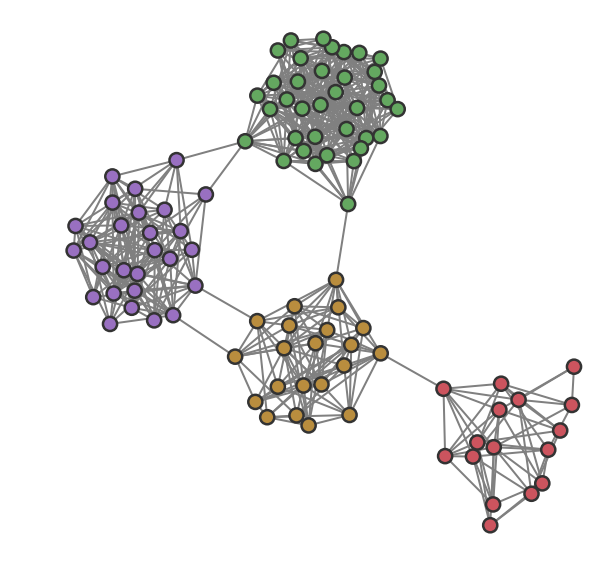

In [9]:
size_dist = np.array([3.0, 2.5, 2.75, 2.25])
ncomms = 4
N = 100; p=0.2; q=0.001
size_dist = softmax(size_dist)
G = random_clustered_network(N, p, q, size_dist)

colors = ["#64a860", "#9970c1", "#b98d3e", "#cc545e"]
nodecols = [colors[i] for i in nx.get_node_attributes(G,'macro').values()]

plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=200, 
                       linewidths=2.5, node_color=nodecols).set_edgecolor('#333333')
nx.draw_networkx_edges(G, pos, edge_color='grey', width=2.0)
plt.axis('off')
plt.show()

In [11]:
def get_chunksize_dict(N, size_dist):
    """Returns an array of size_dist-distributed chunks for your network"""
    chunksize_dist = np.array(size_dist)
    chunksize_dist = sorted(chunksize_dist, reverse=True)
    chunksizes = np.array(N*(chunksize_dist/sum(chunksize_dist)), dtype=int)
    diff_size_check = int(N - sum(chunksizes))
    if diff_size_check > 0:
        for i in range(diff_size_check):
            chunksizes[0] += 1
    if diff_size_check < 0:
        for i in range(np.abs(diff_size_check)):
            chunksizes[0] -= 1

    for i in range(len(chunksizes)):
        if chunksizes[i] == 0:
            chunksizes[0] -= 2
            chunksizes[i] += 2

        if chunksizes[i] == 1:
            chunksizes[0] -= 1
            chunksizes[i] += 1    

    chunk_dict = {}
    curr = 0
    for i in range(len(chunksizes)):
        nums = list(range(curr, curr+chunksizes[i]))
        chunk_dict[i] = nums
        curr = nums[-1]+1
    
    node_chunks_dict = {}
    for k in chunk_dict.keys():
        for i in chunk_dict[k]:
            node_chunks_dict[i] = k
    
    return chunk_dict, node_chunks_dict

def random_clustered_network(N, p, q, size_dist, ret_data=False):
    """
    Creates n_chunk groups of chunksize_dist number of nodes, 
    connecting internally with p and externally with q
    """
    G = nx.Graph()
    all_nodes = list(range(N))
    G.add_nodes_from(all_nodes)

    chunk_dict, node_chunk_dict = get_chunksize_dict(N, size_dist)

    p_edge = 0 
    q_edge = 0 

    for node_i, chunk_k in node_chunk_dict.items():
        # no self-loops
        chunknodes_inside = list(set(chunk_dict[chunk_k])-set([node_i]))
        chunknodes_outside = list(set(all_nodes)-set(chunk_dict[chunk_k]))

        for node_j in chunknodes_inside:
            pp = np.random.rand()
            if (node_i, node_j) not in G.edges() and (node_j, node_i) not in G.edges() and pp < p:
                p_edge += 1
                G.add_edge(node_i, node_j)

        for node_j in chunknodes_outside:
            qq = np.random.rand()
            if (node_i, node_j) not in G.edges() and (node_j, node_i) not in G.edges() and qq < q:
                q_edge += 1
                G.add_edge(node_i, node_j)

    nx.set_node_attributes(G, node_chunk_dict, name='macro')
    if ret_data:
        if p_edge+q_edge>0:
            return G, {'p_edges':p_edge, 'q_edges':q_edge, 'p_frac':p_edge/(p_edge+q_edge)}
        else:
            return G, {'p_edges':0, 'q_edges':0, 'p_frac':np.nan}
    else:
        return G
    
def random_clustered_network_m(N, p, q, size_dist, m=1):
    """
    Creates n_chunk groups of chunksize_dist number of nodes, 
    connecting internally with p and externally with q
    """
    G = nx.Graph()
    all_nodes = list(range(N))
    G.add_nodes_from(all_nodes)

    chunk_dict, node_chunk_dict = get_chunksize_dict(N, size_dist)
    while min([len(chunk) for chunk in chunk_dict.values()]) <= m:
        size_dist = size_dist + softmax(size_dist)
        chunk_dict, node_chunk_dict = get_chunksize_dict(N, size_dist)

    for node_i, chunk_k in node_chunk_dict.items():
        # no self-loops
        prob_dict = {node_i:0}

        chunknodes_inside = list(set(chunk_dict[chunk_k])-set([node_i]))
        chunknodes_outside = list(set(all_nodes)-set(chunk_dict[chunk_k]))
        for ins in chunknodes_inside:
            prob_dict[ins] = p / len(chunknodes_inside)
        for out in chunknodes_outside:
            prob_dict[out] = q / len(chunknodes_outside)

        prob_dict = dict(collections.OrderedDict(sorted(prob_dict.items())))
        probs = np.array(list(prob_dict.values()))
        eijs = np.random.multinomial(m, probs, 1)[0]
        e = np.nonzero(eijs)[0]
        neighbors = G.neighbors(node_i)
        
        while max(eijs) > 1 or max(eijs) < 1 or len([i for i in e if i in neighbors]) > 0:
            eijs = np.random.multinomial(m, probs, 1)[0]
            e = np.nonzero(eijs)[0]

        for node_j in e:
            G.add_edge(node_i, node_j)
            G.add_edge(node_j, node_i)

    nx.set_node_attributes(G, node_chunk_dict, name='macro')
    return G

In [12]:
def get_pos(N, size_dist):
    """Arranges the graphs nicely"""
    pos = {}
    chunk_dict, node_chunk_dict = get_chunksize_dict(N, size_dist)
    ii = 0
    for chunk, nodes in chunk_dict.items():
        G = nx.complete_graph(len(nodes))
        posi = nx.spring_layout(G)
        posi = dict(zip(nodes, np.array(list(posi.values())) + np.array([3*ii,0])))
        pos.update(posi)
        ii += 1
                
    return pos

In [13]:
N = 40
ncomm = 2
size_dist = np.array([N-i for i in range(ncomm)])
nps = 20
ps = np.linspace(0,1,nps)
qs = 1-ps
p_ins = list(zip(ps, qs))
m = 3
ks = np.logspace(-4, 1, nps)

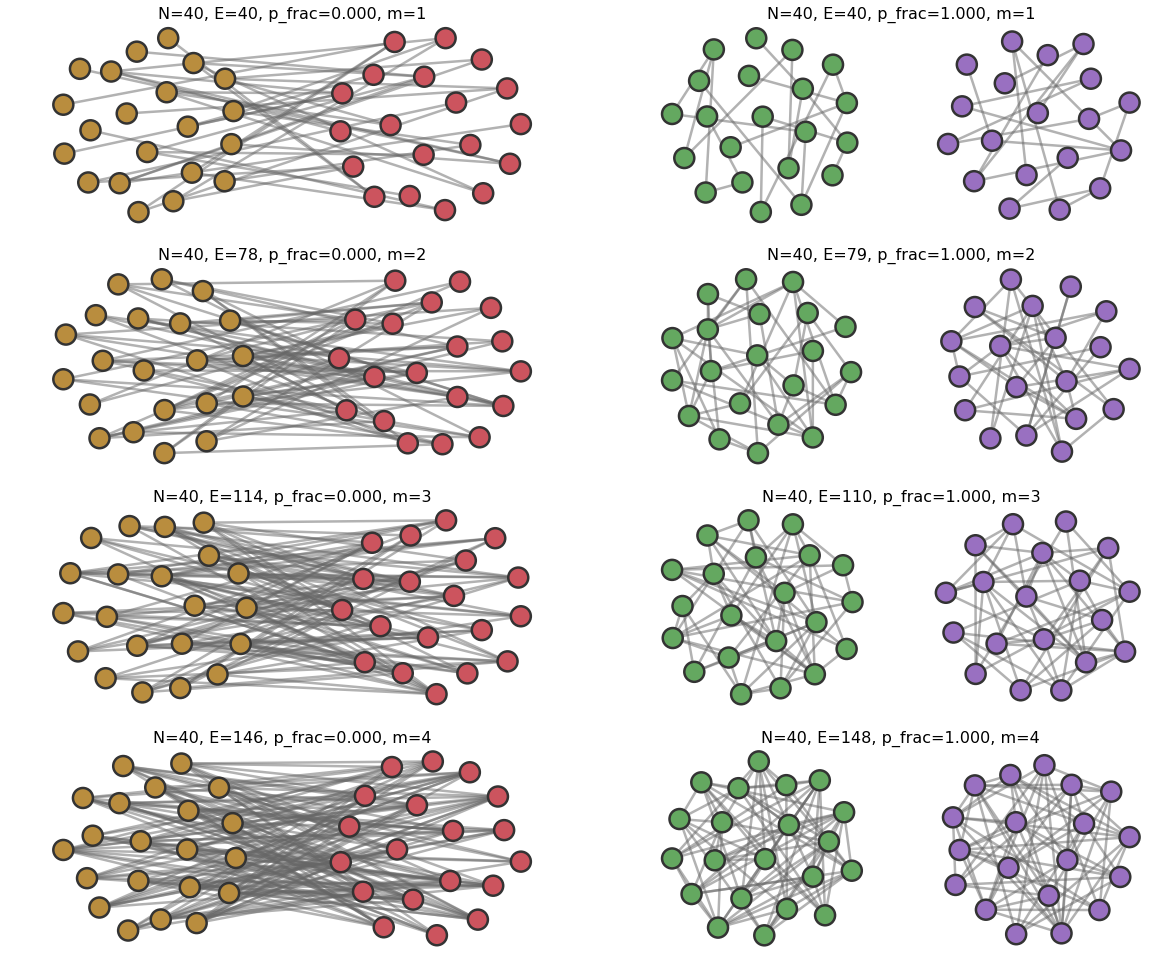

In [14]:
fig, ((ax1, ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(4,2,figsize=(20,17))
ki = 0

i = 0; m=1
colors = ["#b98d3e", "#cc545e", "#64a860", "#9970c1"]
size_dist = np.array([N-i for i in range(ncomm)])
size_dist = softmax(size_dist, ks[ki])
p = p_ins[i][0]; q = p_ins[i][1]
G = random_clustered_network_m(N, p_ins[i][0], p_ins[i][1], size_dist, m)
nodecols = [colors[i] for i in nx.get_node_attributes(G,'macro').values()]
pos = get_pos(N, size_dist)
nx.draw_networkx_nodes(G, pos, node_size=400, linewidths=2.5, node_color=nodecols, ax=ax1).set_edgecolor('#333333')
nx.draw_networkx_edges(G, pos, edge_color='#666666', width=2.5, alpha=0.5, ax=ax1)
ax1.set_axis_off()
ax1.set_title("N=%i, E=%i, p_frac=%.3f, m=%i"%(N, G.number_of_edges(), p_ins[i][0], m), fontsize=16)

i = -1; m=1
colors = ["#64a860", "#9970c1", "#b98d3e", "#cc545e"]
size_dist = np.array([N-i for i in range(ncomm)])
size_dist = softmax(size_dist, ks[ki])
p = p_ins[i][0]; q = p_ins[i][1]
G = random_clustered_network_m(N, p_ins[i][0], p_ins[i][1], size_dist, m)
nodecols = [colors[i] for i in nx.get_node_attributes(G,'macro').values()]
pos = get_pos(N, size_dist)
nx.draw_networkx_nodes(G, pos, node_size=400, linewidths=2.5, node_color=nodecols, ax=ax2).set_edgecolor('#333333')
nx.draw_networkx_edges(G, pos, edge_color='#666666', width=2.5, alpha=0.5, ax=ax2)
ax2.set_axis_off()
ax2.set_title("N=%i, E=%i, p_frac=%.3f, m=%i"%(N, G.number_of_edges(), p_ins[i][0], m), fontsize=16)

i = 0; m=2
colors = ["#b98d3e", "#cc545e", "#64a860", "#9970c1"]
size_dist = np.array([N-i for i in range(ncomm)])
size_dist = softmax(size_dist, ks[ki])
p = p_ins[i][0]; q = p_ins[i][1]
G = random_clustered_network_m(N, p_ins[i][0], p_ins[i][1], size_dist, m)
nodecols = [colors[i] for i in nx.get_node_attributes(G,'macro').values()]
pos = get_pos(N, size_dist)
nx.draw_networkx_nodes(G, pos, node_size=400, linewidths=2.5, node_color=nodecols, ax=ax3).set_edgecolor('#333333')
nx.draw_networkx_edges(G, pos, edge_color='#666666', width=2.5, alpha=0.5, ax=ax3)
ax3.set_axis_off()
ax3.set_title("N=%i, E=%i, p_frac=%.3f, m=%i"%(N, G.number_of_edges(), p_ins[i][0], m), fontsize=16)

i = -1; m=2
colors = ["#64a860", "#9970c1", "#b98d3e", "#cc545e"]
size_dist = np.array([N-i for i in range(ncomm)])
size_dist = softmax(size_dist, ks[ki])
p = p_ins[i][0]; q = p_ins[i][1]
G = random_clustered_network_m(N, p_ins[i][0], p_ins[i][1], size_dist, m)
nodecols = [colors[i] for i in nx.get_node_attributes(G,'macro').values()]
pos = get_pos(N, size_dist)
nx.draw_networkx_nodes(G, pos, node_size=400, linewidths=2.5, node_color=nodecols, ax=ax4).set_edgecolor('#333333')
nx.draw_networkx_edges(G, pos, edge_color='#666666', width=2.5, alpha=0.5, ax=ax4)
ax4.set_axis_off()
ax4.set_title("N=%i, E=%i, p_frac=%.3f, m=%i"%(N, G.number_of_edges(), p_ins[i][0], m), fontsize=16)

i = 0; m=3
colors = ["#b98d3e", "#cc545e", "#64a860", "#9970c1"]
size_dist = np.array([N-i for i in range(ncomm)])
size_dist = softmax(size_dist, ks[ki])
p = p_ins[i][0]; q = p_ins[i][1]
G = random_clustered_network_m(N, p_ins[i][0], p_ins[i][1], size_dist, m)
nodecols = [colors[i] for i in nx.get_node_attributes(G,'macro').values()]
pos = get_pos(N, size_dist)
nx.draw_networkx_nodes(G, pos, node_size=400, linewidths=2.5, node_color=nodecols, ax=ax5).set_edgecolor('#333333')
nx.draw_networkx_edges(G, pos, edge_color='#666666', width=2.5, alpha=0.5, ax=ax5)
ax5.set_axis_off()
ax5.set_title("N=%i, E=%i, p_frac=%.3f, m=%i"%(N, G.number_of_edges(), p_ins[i][0], m), fontsize=16)

i = -1; m=3
colors = ["#64a860", "#9970c1", "#b98d3e", "#cc545e"]
size_dist = np.array([N-i for i in range(ncomm)])
size_dist = softmax(size_dist, ks[ki])
p = p_ins[i][0]; q = p_ins[i][1]
G = random_clustered_network_m(N, p_ins[i][0], p_ins[i][1], size_dist, m)
nodecols = [colors[i] for i in nx.get_node_attributes(G,'macro').values()]
pos = get_pos(N, size_dist)
nx.draw_networkx_nodes(G, pos, node_size=400, linewidths=2.5, node_color=nodecols, ax=ax6).set_edgecolor('#333333')
nx.draw_networkx_edges(G, pos, edge_color='#666666', width=2.5, alpha=0.5, ax=ax6)
ax6.set_axis_off()
ax6.set_title("N=%i, E=%i, p_frac=%.3f, m=%i"%(N, G.number_of_edges(), p_ins[i][0], m), fontsize=16)

i = 0; m=4
colors = ["#b98d3e", "#cc545e", "#64a860", "#9970c1"]
size_dist = np.array([N-i for i in range(ncomm)])
size_dist = softmax(size_dist, ks[ki])
p = p_ins[i][0]; q = p_ins[i][1]
G = random_clustered_network_m(N, p_ins[i][0], p_ins[i][1], size_dist, m)
nodecols = [colors[i] for i in nx.get_node_attributes(G,'macro').values()]
pos = get_pos(N, size_dist)
nx.draw_networkx_nodes(G, pos, node_size=400, linewidths=2.5, node_color=nodecols, ax=ax7).set_edgecolor('#333333')
nx.draw_networkx_edges(G, pos, edge_color='#666666', width=2.5, alpha=0.5, ax=ax7)
ax7.set_axis_off()
ax7.set_title("N=%i, E=%i, p_frac=%.3f, m=%i"%(N, G.number_of_edges(), p_ins[i][0], m), fontsize=16)

i = -1; m=4
colors = ["#64a860", "#9970c1", "#b98d3e", "#cc545e"]
size_dist = np.array([N-i for i in range(ncomm)])
size_dist = softmax(size_dist, ks[ki])
p = p_ins[i][0]; q = p_ins[i][1]
G = random_clustered_network_m(N, p_ins[i][0], p_ins[i][1], size_dist, m)
nodecols = [colors[i] for i in nx.get_node_attributes(G,'macro').values()]
pos = get_pos(N, size_dist)
nx.draw_networkx_nodes(G, pos, node_size=400, linewidths=2.5, node_color=nodecols, ax=ax8).set_edgecolor('#333333')
nx.draw_networkx_edges(G, pos, edge_color='#666666', width=2.5, alpha=0.5, ax=ax8)
ax8.set_axis_off()
ax8.set_title("N=%i, E=%i, p_frac=%.3f, m=%i"%(N, G.number_of_edges(), p_ins[i][0], m), fontsize=16)

# plt.savefig("../figs/pngs/Rgg_example.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/Rgg_example.pdf", bbox_inches='tight')

plt.show()

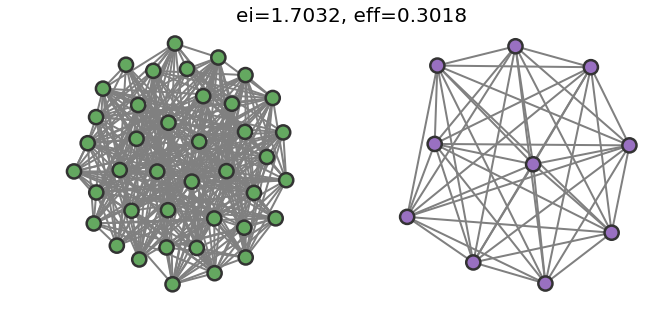

In [16]:
size_dist = np.array([40.0, 10.0])
ncomms = 2
N = 50; p = 1.0; q = 1-p
G = random_clustered_network_m(N, p, q, size_dist, m=int(size_dist[1]-1))

#selfloops 
for i in G.nodes():
    G.add_edge(i,i)

colors = ["#64a860", "#9970c1", "#b98d3e", "#cc545e"]
nodecols = [colors[i] for i in nx.get_node_attributes(G,'macro').values()]

plt.figure(figsize=(11,5))
pos = nx.spring_layout(G)
pos = get_pos(N, size_dist)
# pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=200, 
                       linewidths=2.5, node_color=nodecols).set_edgecolor('#333333')
nx.draw_networkx_edges(G, pos, edge_color='grey', width=2.0)
plt.title("ei=%.4f, eff=%.4f"%(get_ei(G, p0=0),get_ei(G, p0=0)/np.log2(N)),size=20)
plt.axis('off')
plt.show()

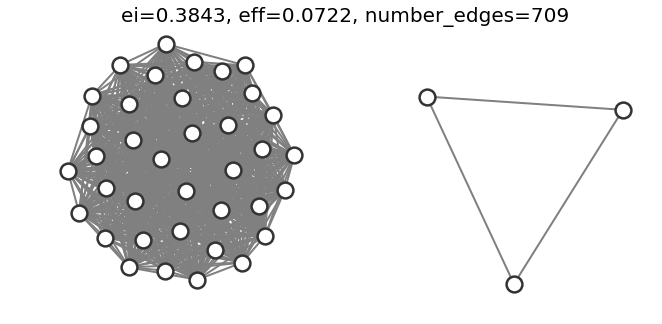

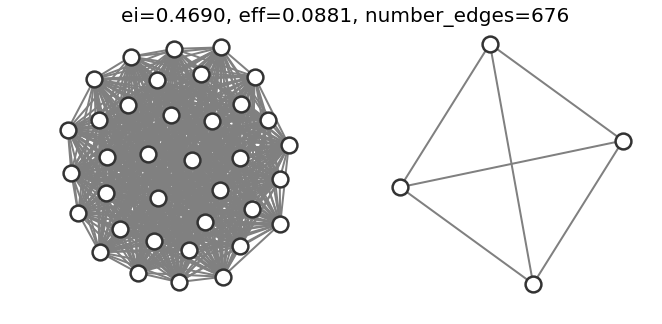

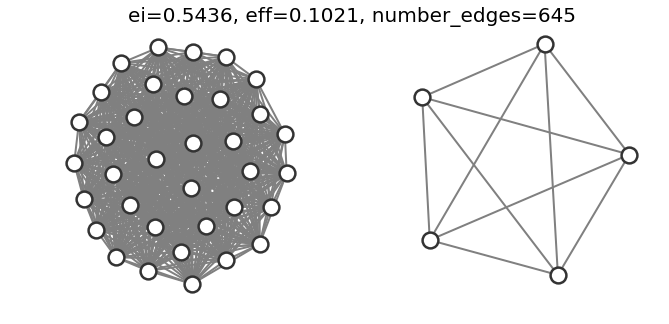

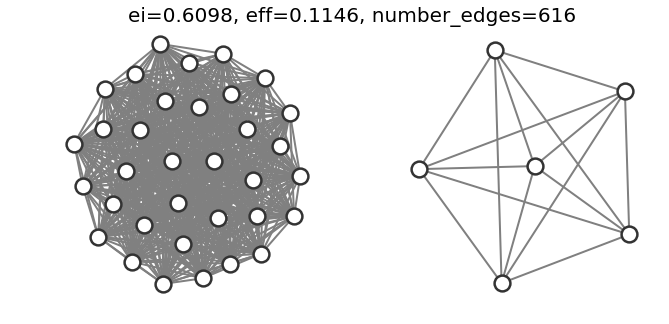

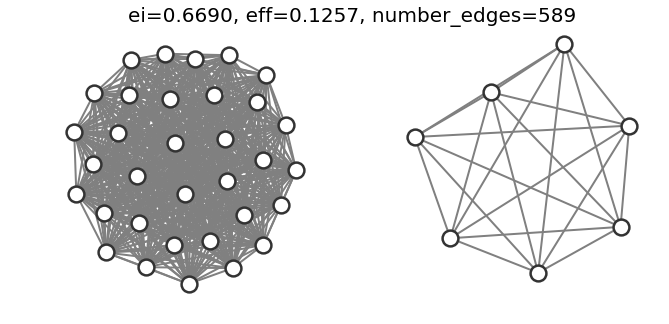

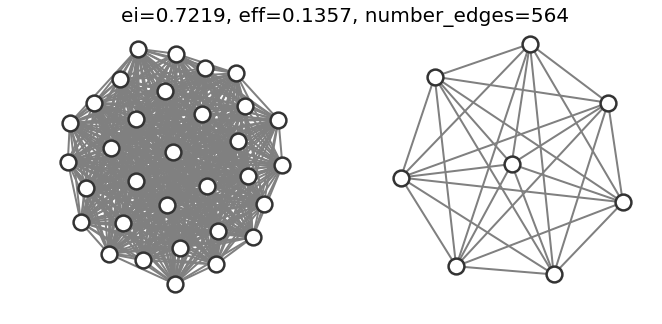

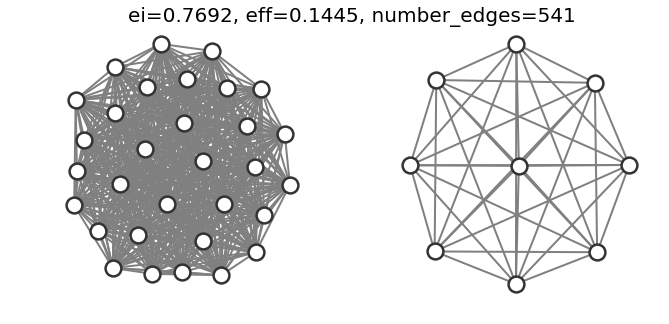

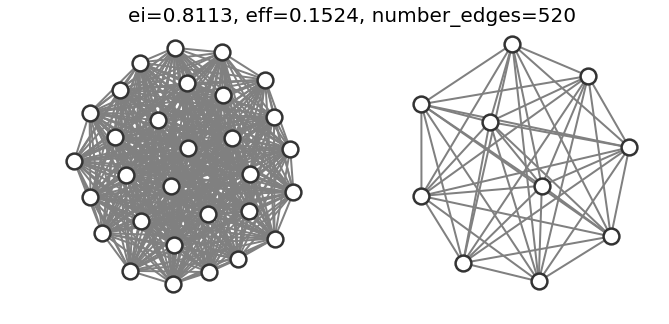

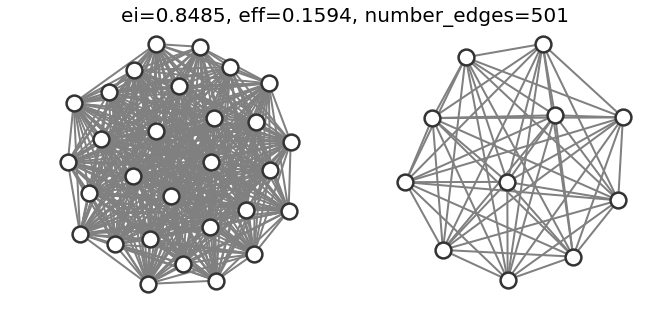

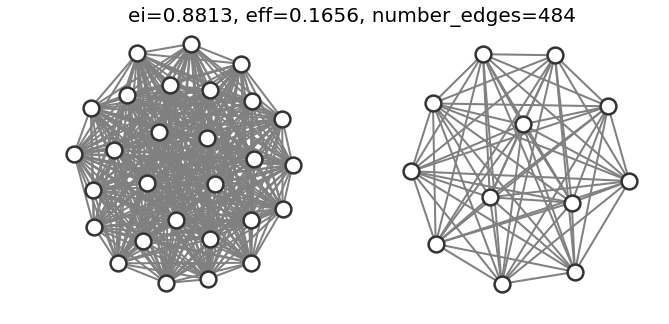

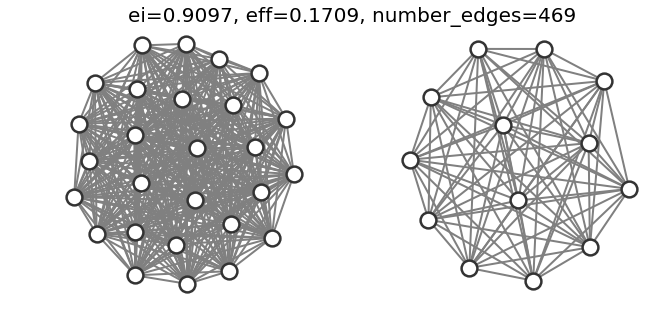

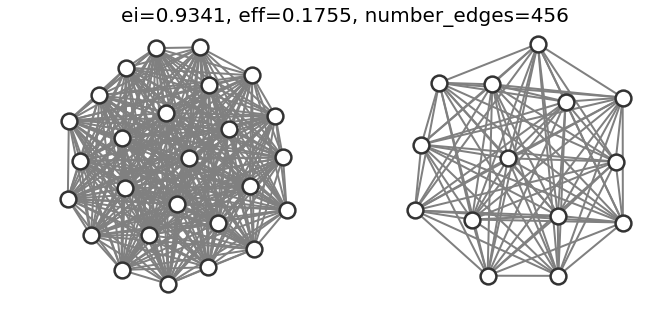

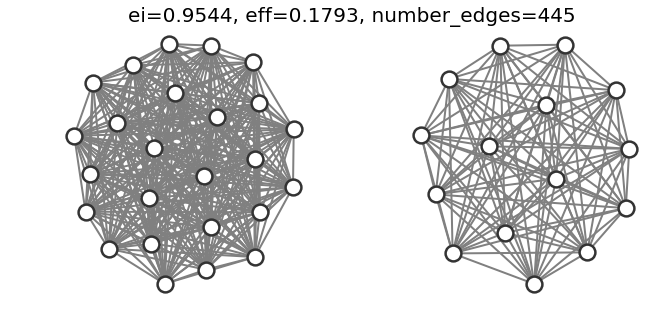

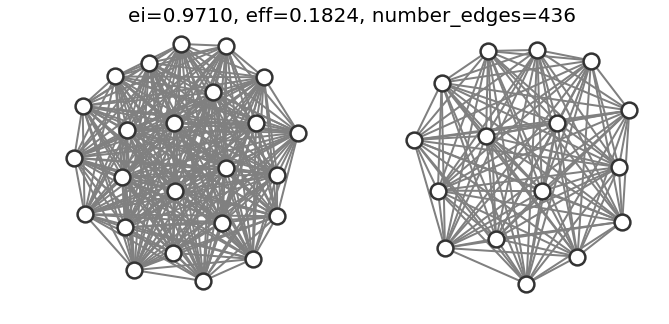

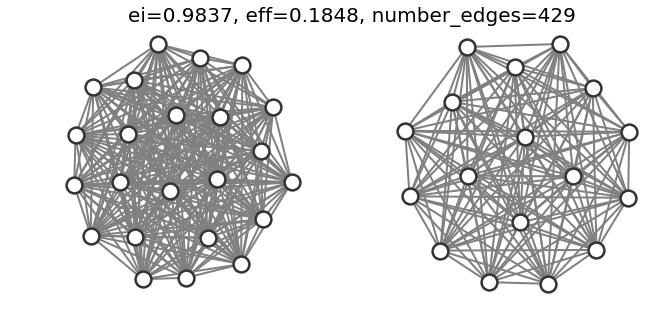

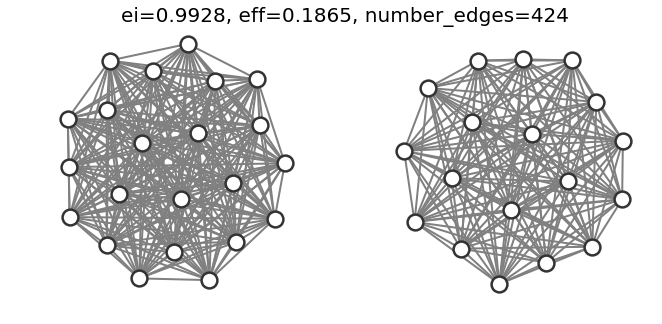

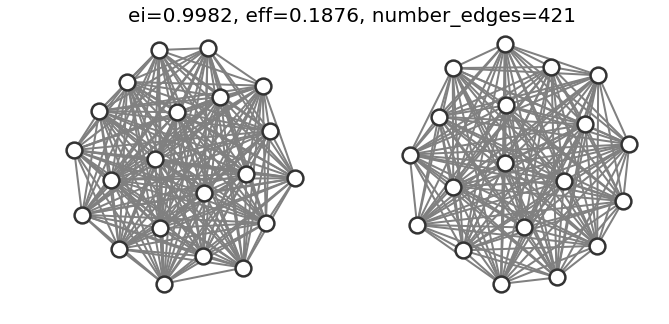

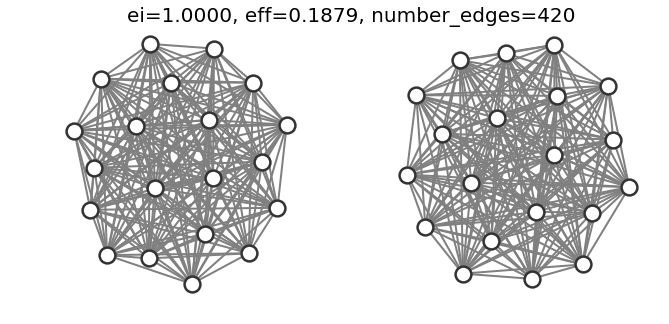

In [107]:
eis = []
efs = []
N = 40 
ranges = list(range(3,int(N/2+1)))
for i in ranges:
    size_dist = np.array([40-i, i])
    N = sum(size_dist)
    ncomms = 2

    G1 = nx.complete_graph(size_dist[0])
    nx.set_node_attributes(G1, [0]*size_dist[0], 'macro')
    for i in G1.nodes():
        G1.add_edge(i,i)
    maxnode = max(list(G1.nodes()))
    G2 = nx.complete_graph(size_dist[1])
    nx.set_node_attributes(G2, [1]*size_dist[1], 'macro')
    G2 = nx.relabel_nodes(G2, dict(zip(list(G1.nodes()), list(range(maxnode+1,maxnode+1+size_dist[1])))))
    for i in G2.nodes():
        G2.add_edge(i,i)
    G = nx.Graph()
    G.add_nodes_from(G1.nodes())
    G.add_nodes_from(G2.nodes())

    G.add_edges_from(G1.edges())
    G.add_edges_from(G2.edges())
#     nx.set_node_attributes(G, [0]*size_dist[0]+[1]*size_dist[1], 'macro')
    #selfloops 
#     for i in G.nodes():
#         G.add_edge(i,i)

    colors = ["#64a860", "#9970c1", "#b98d3e", "#cc545e"]
    nodecols = [colors[i] for i in nx.get_node_attributes(G,'macro').values()]
    eis.append(get_ei(G, p0=0))
    efs.append(get_ei(G, p0=0)/np.log2(N))
    plt.figure(figsize=(11,5))
    pos = nx.spring_layout(G)
    pos = get_pos(N, size_dist)
    # pos = nx.kamada_kawai_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=250, 
                           linewidths=2.5, node_color='w').set_edgecolor('#333333')
    #                        linewidths=2.5, node_color=nodecols).set_edgecolor('#333333')
    nx.draw_networkx_edges(G, pos, edge_color='grey', width=2.0)
    plt.title("ei=%.4f, eff=%.4f, number_edges=%i"%(get_ei(G, p0=0),get_ei(G, p0=0)/np.log2(N), 
                                                    G.number_of_edges()),size=20)
    plt.axis('off')
    plt.show()

In [279]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		# I'm ignoring masked values and all kinds of edge cases to make a
		# simple example...
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [353]:
N = 80
n_times = int(N/2)
ranges = np.arange(3, int(N/2)+1, 1, dtype=int)

out_ei = []
out_pi = []
out_ss = []
out_ce = []
out_sd = []
pin_probs = np.linspace(0, 1, len(ranges))
pin_probs = sorted(np.unique(list(np.logspace(-2,0,len(ranges)/2-1)*0.5) + \
                             list(1-np.logspace(-2,0,len(ranges)/2-1)*0.5)))
pin_probs.append(0.0)
pin_probs.append(1.0)
pin_probs = sorted(pin_probs)
pin_probs

out_df = pd.DataFrame(columns=['p_in', 'sizes', 'iter', 'ce'])
test_out_pfrac = []
test_out_asymm = []
test_out_causa = []
# ranges = [ranges[0]]

for i in ranges:
    print("Starting iteration %02i at %s"%(i, dt.datetime.now()))
    sizes = [N-i, i]
    macros = [0]*sizes[0] + [1]*sizes[1]
    for p_in in pin_probs:
        out_ei_i = []
        out_pi_i = []
        out_ss_i = []
        out_ce_i = []
        p_ex = 1-p_in
        
        for nn in range(n_times):
            edge_left = 0
            dat = {'p_in':[p_in], 'sizes':[sizes[0]/N], 'iter':[nn]}
            G = nx.DiGraph()
#             G = nx.Graph()
            G.add_nodes_from(list(range(sum(sizes))))
            nx.set_node_attributes(G, dict(zip(G.nodes(),list(np.array(macros)+N))), 'macro')
            
            probs = [p_in]*sizes[0] + [p_ex]*sizes[1]
            for node_i in list(G.nodes())[:sizes[0]]:
                for node_j in list(G.nodes()):
                    if np.random.rand() < probs[node_j] and node_i!=node_j:
                        G.add_edge(node_i, node_j)
                        edge_left += 1
                        
#                         G.add_edge(node_j, node_i)

            probs = [p_ex]*sizes[0] + [p_in]*sizes[1]
            for node_i in list(G.nodes())[sizes[0]:]:
                for node_j in list(G.nodes()):
                    if np.random.rand() < probs[node_j] and node_i!=node_j:
                        G.add_edge(node_i, node_j)
#                         G.add_edge(node_j, node_i)

            test_out_pfrac.append(edge_left/G.number_of_edges())
            test_out_asymm.append((N-i)/N)
                        
            current_ei = get_ei(G, p0=0)

            mac_map = nx.get_node_attributes(G, 'macro')
            mG = get_macro(G, mac_map, p0=0)
            macro_ei = get_ei(mG, p0=0)
            dat['ce'] = [current_ei-macro_ei]
            test_out_causa.append(current_ei-macro_ei)
            
            out_df = out_df.append(pd.DataFrame(dat))

Starting iteration 03 at 2018-12-07 12:15:36.152106
Starting iteration 04 at 2018-12-07 12:16:22.289850
Starting iteration 05 at 2018-12-07 12:17:13.634379
Starting iteration 06 at 2018-12-07 12:18:02.488425
Starting iteration 07 at 2018-12-07 12:18:52.501481
Starting iteration 08 at 2018-12-07 12:19:42.253211
Starting iteration 09 at 2018-12-07 12:20:32.693043
Starting iteration 10 at 2018-12-07 12:21:23.268196
Starting iteration 11 at 2018-12-07 12:22:12.529486
Starting iteration 12 at 2018-12-07 12:23:01.017678
Starting iteration 13 at 2018-12-07 12:23:48.640258
Starting iteration 14 at 2018-12-07 12:24:39.834518
Starting iteration 15 at 2018-12-07 12:25:30.359661
Starting iteration 16 at 2018-12-07 12:26:22.617796
Starting iteration 17 at 2018-12-07 12:27:10.315216
Starting iteration 18 at 2018-12-07 12:27:56.089208
Starting iteration 19 at 2018-12-07 12:28:41.987500
Starting iteration 20 at 2018-12-07 12:29:28.945274
Starting iteration 21 at 2018-12-07 12:30:14.747133
Starting ite

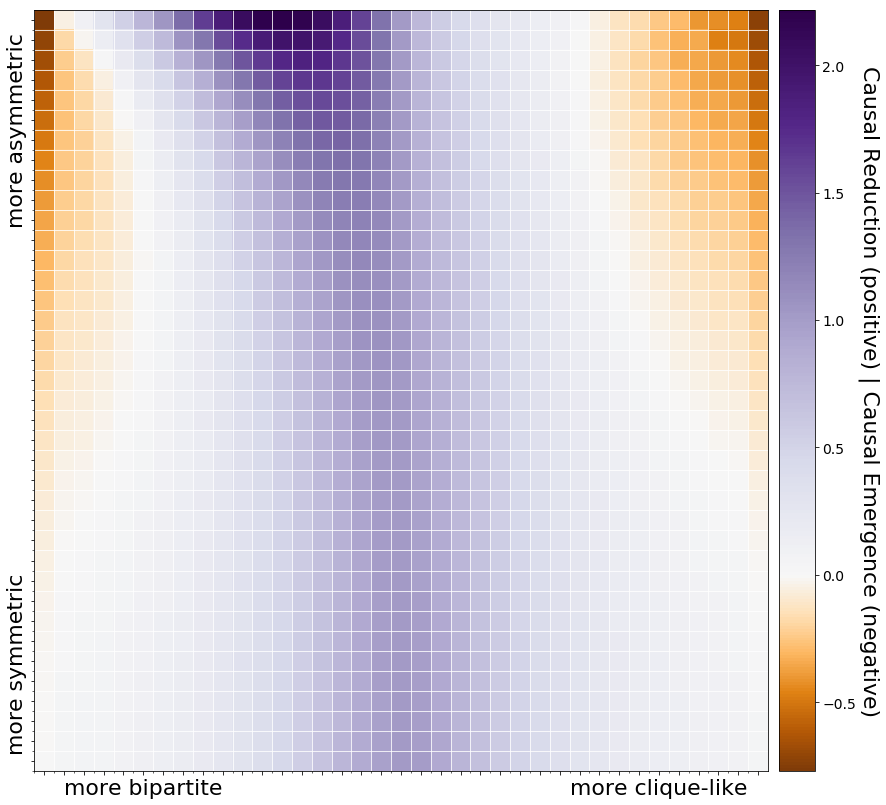

In [364]:
################################################################
imsho_ce = np.array(out_df.groupby(['p_in','sizes'])['ce'].
                    mean()).reshape((len(pin_probs), len(ranges))).T
imsho_sd = np.array(out_df.groupby(['p_in','sizes'])['ce'].
                    var()).reshape((len(pin_probs), len(ranges))).T
imsho_ma = np.array(out_df.groupby(['p_in','sizes'])['ce'].
                    max()).reshape((len(pin_probs), len(ranges))).T
imsho_mi = np.array(out_df.groupby(['p_in','sizes'])['ce'].
                    min()).reshape((len(pin_probs), len(ranges))).T
maxval_ce = max(imsho_ce.flatten())
minval_ce = min(imsho_ce.flatten())#*0.75
# if np.abs(minval_ce) > np.abs(maxval_ce):
#     maxval_ce = np.abs(minval_ce)
# else:
#     minval_ce = -maxval_ce
maxval_sd = max(imsho_sd.flatten())
minval_sd = min(imsho_sd.flatten())
maxval_ma = max(imsho_ma.flatten())
minval_ma = min(imsho_ma.flatten())
maxval_mi = max(imsho_mi.flatten())
minval_mi = min(imsho_mi.flatten())
xtix = pin_probs
ytix = (N-np.array(sorted(ranges, reverse=True)))/N
xlab = "Fraction of Within-Cluster Connections"
ylab = "Number of Nodes in Right-Side Cluster"
cba0 = "Causal Reduction (positive) | Causal Emergence (negative)"
# cba0 = "Micro EI - Macro EI"
cba1 = "Variance of Micro EI - Macro EI"
cba2 = "Maximum of Micro EI - Macro EI"
cba3 = "Minimum of Micro EI - Macro EI"
tit0 = "Stochastic Block Models and Causal Emergence\n N = %i, n_iter = %i"%(N,n_times)
fs = 22
################################################################

fig, ax0 = plt.subplots(1, 1, figsize=(14,14))
################################
# subplot1 

im_ce = ax0.imshow(imsho_ce, cmap=plt.cm.PuOr, aspect='auto', origin='lower',
                   clim=(minval_ce, maxval_ce), norm=MidpointNormalize(midpoint=0,vmin=minval_ce, vmax=maxval_ce))
#                    vmin=minval_ce, vmax=maxval_ce)
divider=make_axes_locatable(ax0); cax=divider.append_axes("right", size="5%", pad=0.15)
cb = plt.colorbar(im_ce, cax=cax)
cb.set_label(cba0, fontsize=fs, rotation=270, labelpad=23.0)
cb.ax.tick_params(labelsize=14) 

################################
# subplot labeling
# ax0.text(10.0, -1.38, tit0, fontsize=28)
# ax0.set_title(tit0, size=24)

xtl = ['']*5+ ['more bipartite'] + [""]*(len(xtix)-12)+ ['more clique-like'] + ['']*4
ytl = ['']*9+ ['more symmetric'] + [""]*(len(ytix)-12)+ ['more asymmetric'] #+ ['']

# ax0.set_xlabel(xlab, size=24)
# ax0.set_ylabel(ylab, size=24)
ax0.set_xticks(np.array(list(range(len(xtix)))))
ax0.set_yticks(np.array(list(range(len(ytix)))))
# ax0.set_xticklabels(["%.4f"%i for i in xtix], size=14)
# ax0.set_yticklabels(["%.2f"%i for i in ytix], size=14)
ax0.set_xticklabels(xtl, size=fs)
ax0.set_yticklabels(ytl, size=fs, rotation=90)
ax0.set_xticks(np.array(list(range(len(xtix))))-0.5, minor=True)
ax0.set_yticks(np.array(list(range(len(ytix))))-0.5, minor=True)
ax0.grid(which='minor', linestyle='-', color='w', linewidth=1.0, alpha=0.8)

# plt.savefig("../figs/pngs/CausalEmergence_SBM_mean_N80.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/CausalEmergence_SBM_mean_N80.pdf", bbox_inches='tight')
plt.show()

In [ ]:
fig, ax0 = plt.subplots(1, 1, figsize=(14,14))
################################
# subplot1 
im_ce = ax0.imshow(imsho_ce, cmap=plt.cm.RdGy, vmin=minval_ce, vmax=maxval_ce, aspect='auto', origin='lower')
divider=make_axes_locatable(ax0); cax=divider.append_axes("right", size="5%", pad=0.15)

x = np.array(test_out_pfrac) + np.random.normal(0.0, 0.05, len(test_out_pfrac))
y = np.array(test_out_asymm) + np.random.normal(0.0, 0.05, len(test_out_asymm))

xxx = ax0.scatter(x,y,c=test_out_causa, cmap=plt.cm.RdGy, vmin=minval_ce, 
                  vmax=maxval_ce, marker='.', alpha=0.25, s=100)
divider=make_axes_locatable(ax0); cax=divider.append_axes("right", size="5%", pad=0.15)
cb = plt.colorbar(xxx, cax=cax)
cb.set_label(cba0, fontsize=24, rotation=270, labelpad=26.0)
cb.ax.tick_params(labelsize=14) 


ax0.set_xlabel('Fraction of edges within left side (?)', size=18)
ax0.set_ylabel('Asymmetry', size=18)
# plt.xticks(np.linspace(0,1,11),fontsize=14)
# plt.yticks(np.linspace(0,1,11),fontsize=14)
ax0.set_xlim(0.45, 1.0)
ax0.set_ylim(0.5, 0.95)
ax0.grid(color='grey', alpha=0.5, linestyle='--', linewidth=2.0)
plt.show()

In [ ]:
# ################################################################
# imsho_ce = np.array(out_df.groupby(['p_in','sizes'])['ce'].
#                     mean()).reshape((len(pin_probs), len(ranges))).T
# imsho_sd = np.array(out_df.groupby(['p_in','sizes'])['ce'].
#                     var()).reshape((len(pin_probs), len(ranges))).T
# imsho_ma = np.array(out_df.groupby(['p_in','sizes'])['ce'].
#                     max()).reshape((len(pin_probs), len(ranges))).T
# imsho_mi = np.array(out_df.groupby(['p_in','sizes'])['ce'].
#                     min()).reshape((len(pin_probs), len(ranges))).T
# maxval_ce = max(imsho_ce.flatten())*0.75
# minval_ce = min(imsho_ce.flatten())*0.75
# if np.abs(minval_ce) > np.abs(maxval_ce):
#     maxval_ce = np.abs(minval_ce)
# else:
#     minval_ce = -maxval_ce
# maxval_sd = max(imsho_sd.flatten())
# minval_sd = min(imsho_sd.flatten())
# maxval_ma = max(imsho_ma.flatten())
# minval_ma = min(imsho_ma.flatten())
# maxval_mi = max(imsho_mi.flatten())
# minval_mi = min(imsho_mi.flatten())
# xtix = pin_probs
# ytix = (N-ranges)/N
# xlab = "Fraction of Within-Cluster Connections"
# ylab = "Number of Nodes in Right-Side Cluster"
# cba0 = "Micro EI - Macro EI"
# cba1 = "Variance of Micro EI - Macro EI"
# cba2 = "Maximum of Micro EI - Macro EI"
# cba3 = "Minimum of Micro EI - Macro EI"
# tit0 = "Stochastic Block Models and Causal Emergence\n N = %i, n_iter = %i"%(N,n_times)
# ################################################################

# fig, ax0 = plt.subplots(1, 1, figsize=(14,14))
# ################################
# # subplot1 
# im_ce = ax0.imshow(imsho_ce, cmap=plt.cm.RdGy, vmin=minval_ce, vmax=maxval_ce, aspect='auto', origin='lower')
# divider=make_axes_locatable(ax0); cax=divider.append_axes("right", size="5%", pad=0.15)
# cb = plt.colorbar(im_ce, cax=cax)
# cb.set_label(cba0, fontsize=24, rotation=270, labelpad=26.0)
# cb.ax.tick_params(labelsize=14) 

# ################################
# # subplot labeling
# # ax0.text(10.0, -1.38, tit0, fontsize=28)
# # ax0.set_title(tit0, size=24)
# ax0.set_xlabel(xlab, size=24)
# ax0.set_ylabel(ylab, size=24)
# ax0.set_xticks(np.array(list(range(len(xtix)))))
# ax0.set_yticks(np.array(list(range(len(ytix)))))
# ax0.set_xticklabels(["%.2f"%i for i in xtix], size=14)
# ax0.set_yticklabels(["%.2f"%i for i in ytix], size=14)
# ax0.set_xticks(np.array(list(range(len(xtix))))-0.5, minor=True)
# ax0.set_yticks(np.array(list(range(len(ytix))))-0.5, minor=True)
# ax0.grid(which='minor', linestyle='-', color='gainsboro', linewidth=2.0, alpha=0.8)

# plt.savefig("../figs/pngs/CausalEmergence_SBM_std_N32.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/CausalEmergence_SBM_std_N32.pdf", bbox_inches='tight')
# plt.show()